In [58]:
cd /content

/content


In [59]:

!ls

cs231n_stanford_2019  google-colab-cs231n  sample_data


In [60]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

fatal: destination path 'google-colab-cs231n' already exists and is not an empty directory.


In [61]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [15]:
!pip install imageio

In [62]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
cifar-10-batches-py  get_datasets.sh


In [63]:
!./get_datasets.sh

--2019-12-20 11:00:55--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2019-12-20 11:00:56 ERROR 500: Internal Server Error.

tar (child): cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
rm: cannot remove 'cifar-10-python.tar.gz': No such file or directory


In [64]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [65]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 

In [74]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.366566
sanity check: 2.302585


In [80]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.257409 analytic: -0.257409, relative error: 7.868889e-08
numerical: -0.262253 analytic: -0.262253, relative error: 2.649960e-08
numerical: -0.690027 analytic: -0.690027, relative error: 6.628359e-09
numerical: -1.916327 analytic: -1.916327, relative error: 3.539961e-08
numerical: -3.484792 analytic: -3.484792, relative error: 6.967644e-10
numerical: -1.085177 analytic: -1.085177, relative error: 2.793349e-09
numerical: 0.741142 analytic: 0.741142, relative error: 8.292089e-08
numerical: 2.004517 analytic: 2.004517, relative error: 1.818455e-09
numerical: 0.217801 analytic: 0.217801, relative error: 1.060330e-07
numerical: 0.188091 analytic: 0.188091, relative error: 1.554257e-07
numerical: -1.936384 analytic: -1.936384, relative error: 3.318129e-09
numerical: 1.113428 analytic: 1.113428, relative error: 1.036381e-08
numerical: -3.068142 analytic: -3.068142, relative error: 1.630323e-08
numerical: 0.087217 analytic: 0.087217, relative error: 6.735002e-07
numerical: -1.4849

In [82]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.366566e+00 computed in 0.205526s
vectorized loss: 2.366566e+00 computed in 0.016573s
Loss difference: 0.000000
Gradient difference: 0.000000


In [86]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 5e-6, 1e-7, 5e-7]
regularization_strengths = [5e2, 5e3, 2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
hparams = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]
for lr, reg in hparams:
    softmax = Softmax()
    _ = softmax.train(X_train, y_train, learning_rate=lr, 
                      reg=reg,
                      num_iters=1500, verbose=False)
    train_acc = np.mean(y_train == softmax.predict(X_train))
    val_acc = np.mean(y_val == softmax.predict(X_val))
    results[(lr, reg)] = (train_acc, val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.258286 val accuracy: 0.256000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.289878 val accuracy: 0.319000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.351469 val accuracy: 0.372000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.330184 val accuracy: 0.341000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.339939 val accuracy: 0.342000
lr 5.000000e-07 reg 5.000000e+03 train accuracy: 0.386694 val accuracy: 0.404000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.346755 val accuracy: 0.362000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.330224 val accuracy: 0.347000
lr 1.000000e-06 reg 5.000000e+02 train accuracy: 0.386469 val accuracy: 0.397000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.387163 val accuracy: 0.396000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.338408 val accuracy: 0.335000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.330286 val accuracy: 0.342000
lr 5.000000e-06 reg 5.000000

In [89]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.382000


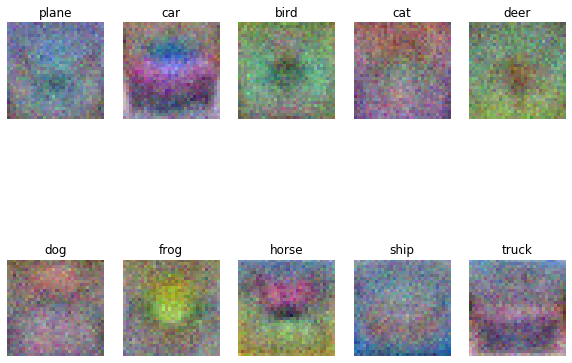

In [90]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])